### Testing Spherical Vs Cylindrical

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import gaussian

In [7]:
def motor_dist(r, m0, R, l):
    r_calc = m0 * np.e ** (R-r/l)
    r_changed = np.array(r)
    r_changed[r_changed>R] = 0
    r_changed[r<=R] = 1
    
    r_changed = r_changed * r_calc
    r_changed[r==0] = m0
    return r_changed

def norm(a):
    return a/np.sum(a)

def gaussian_sigma(r,R,maximum = 10):
    return maximum*(((R-r)**2)**0.5)/R
    

In [8]:
length_px = 100
length_um = 600
pixels_to_um = length_um/length_px
um_to_pixels = 1/pixels_to_um

n_motors = 10**6
R_px = 50
R_um = pixels_to_um*R_px

l=30

v_sph = 4/3 * np.pi * (R_um ** 3)

h_cyl = v_sph / (2 * np.pi * (R_um ** 2))
v_cyl = 2 * np.pi * (R_um ** 2) * h_cyl

m0_sph =  v_sph / n_motors
m0_cyl =  v_cyl / n_motors

h_cyl_px = h_cyl * um_to_pixels
h_sph_px = R_px * 2

print(m0_cyl)
print(m0_sph)
print(R_um)

113.09733552923255
113.09733552923255
300.0


In [18]:
dist_cyl = np.zeros((length_px,length_px,int(h_cyl*um_to_pixels)))

for i in range(length_px):
    for j in range(length_px):
        r = (((i-length_px/2)**2+(j-length_px/2)**2)**(0.5)) * pixels_to_um
        dist_cyl[i,j,:] = np.ones(dist_cyl.shape[2])*r

dist_cyl = motor_dist(dist_cyl, m0_cyl, R_um, l)
dist_cyl = dist_cyl / np.sum(dist_cyl)


dist_sph = np.zeros((length_px,length_px,length_px))

for i in range(length_px):
    for j in range(length_px):
        for k in range(length_px):
            r = (((i-length_px/2)**2+(j-length_px/2)**2+(k-length_px/2)**2)**(0.5)) * pixels_to_um
            dist_sph[i,j,k] = r
            
dist_sph = motor_dist(dist_sph, m0_sph, R_um, l)
dist_sph = dist_sph / np.sum(dist_sph)


In [20]:
cyl = np.zeros((length_px,length_px,int(h_cyl*um_to_pixels)))
sph = np.zeros((length_px,length_px,length_px))

one_d_sph = np.sum(np.sum(dist_sph, axis = 2), axis = 1)
one_d_cyl = np.sum(np.sum(dist_cyl, axis = 2), axis = 1)

sampleList_sph = range(len(one_d_sph))
sampleList_cyl = range(len(one_d_sph))

for x in range(1000):
    random_sph_i = np.random.choice(sampleList_sph, 1, p=one_d_sph)[0]
    random_cyl_i = np.random.choice(sampleList_cyl, 1, p=one_d_cyl)[0]
    
    two_d_sph = norm(np.sum(dist_sph[random_sph_i,:,:], axis = 1))
    two_d_cyl = norm(np.sum(dist_sph[random_cyl_i,:,:], axis = 1))
    sampleList_sph_2 = range(len(two_d_sph))
    sampleList_cyl_2 = range(len(two_d_sph))
    
    random_sph_j = np.random.choice(sampleList_sph_2, 1, p=two_d_sph)[0]
    random_cyl_j = np.random.choice(sampleList_cyl_2, 1, p=two_d_cyl)[0]
    
    
    three_d_sph = norm(dist_sph[random_sph_i,random_sph_j,:])
    three_d_cyl = norm(dist_cyl[random_cyl_i,random_cyl_j,:])
    sampleList_sph_3 = range(len(dist_sph[random_sph_i,random_sph_j,:]))
    sampleList_cyl_3 = range(len(dist_cyl[random_cyl_i,random_cyl_j,:]))
    
    random_sph_k = np.random.choice(sampleList_sph_3, 1, p=three_d_sph)[0]
    random_cyl_k = np.random.choice(sampleList_cyl_3, 1, p=three_d_cyl)[0]
    
    sph[random_sph_i,random_sph_j,random_sph_k] += 1
    cyl[random_cyl_i,random_cyl_j,random_cyl_k] += 1

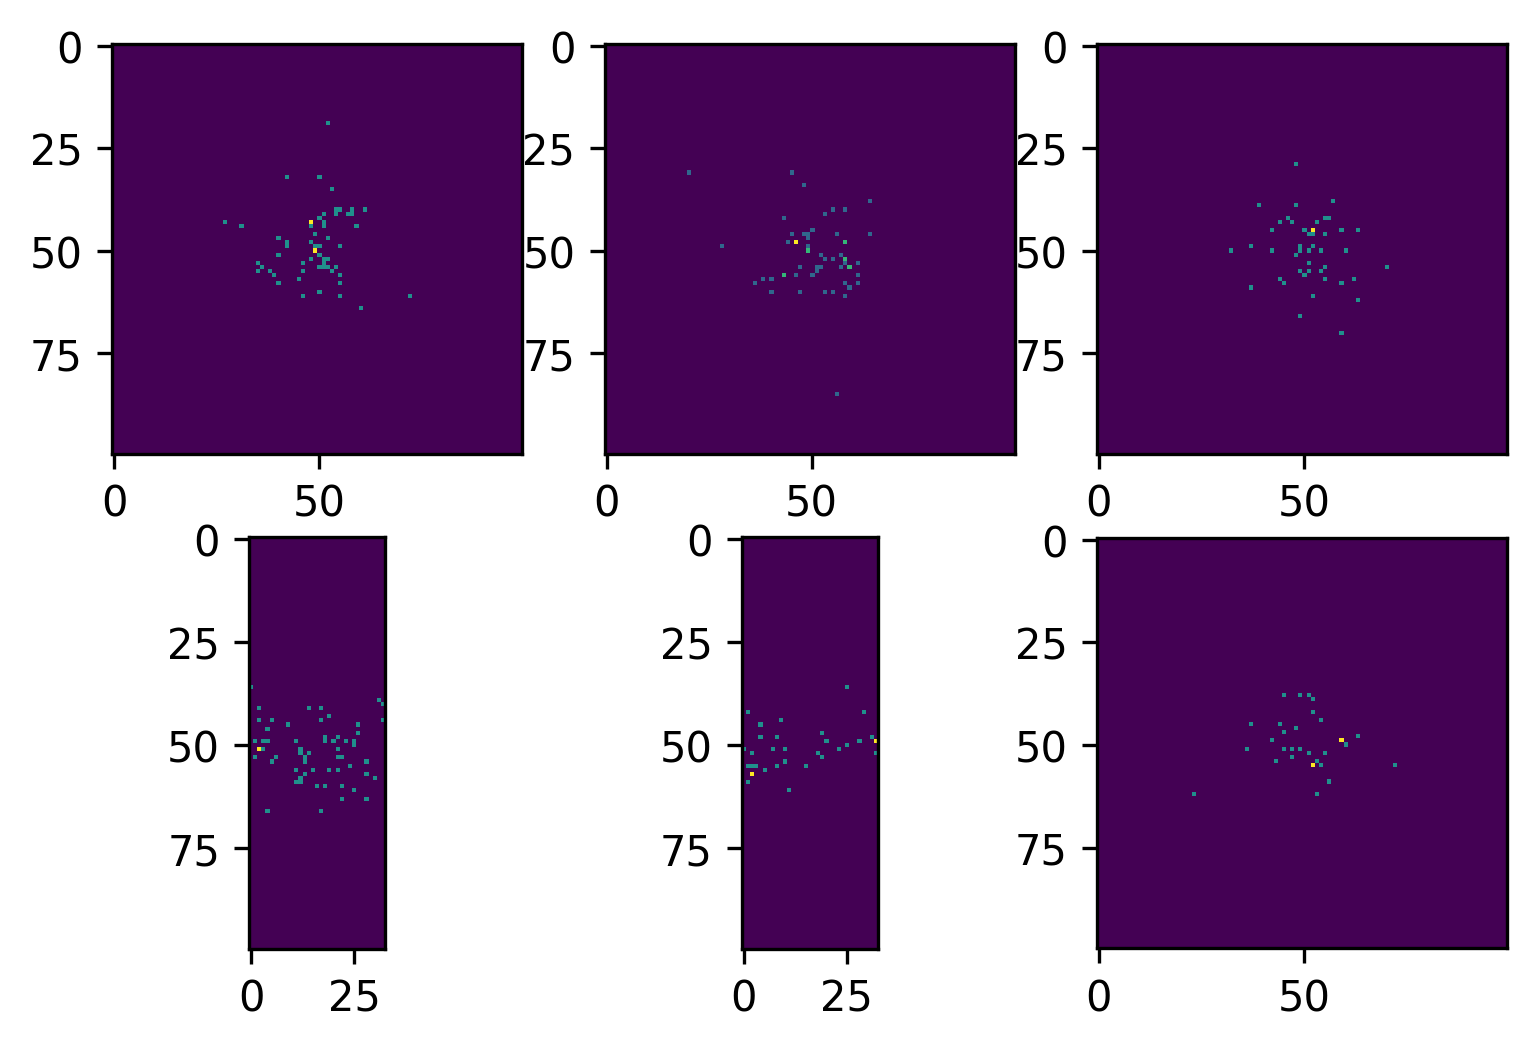

In [21]:
fig, axs = plt.subplots(2,3,dpi=300)

axs[0,0].imshow(sph[50,:,:])
axs[0,1].imshow(sph[:,50,:])
axs[0,2].imshow(sph[:,:,50])
axs[1,0].imshow(cyl[50,:,:])
axs[1,1].imshow(cyl[:,50,:])
axs[1,2].imshow(cyl[:,:,16])

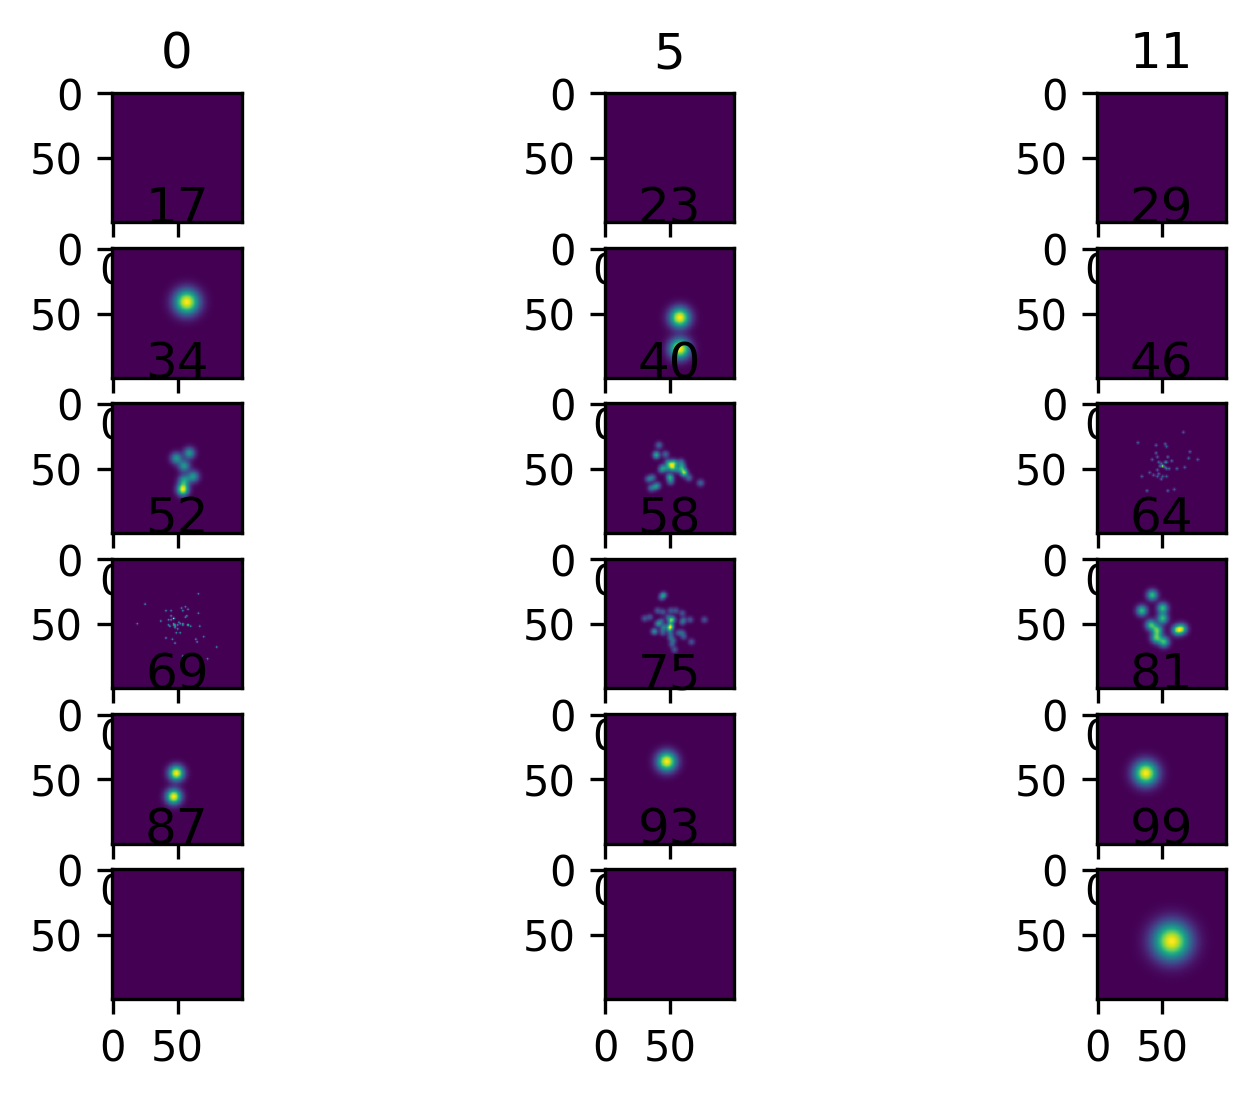

In [22]:
fig, axs = plt.subplots(6,3,dpi=300)
hs = np.linspace(0,h_sph_px-1,6*3)

for i in range(len(axs)):
    for j in range(len(axs[0])):
        dst = gaussian(sph[:,:,int(hs[3*i+j])], sigma=gaussian_sigma(hs[3*i+j],h_sph_px/2))
        axs[i,j].imshow(dst)
        axs[i,j].set(title = f'{int(hs[3*i+j])}')

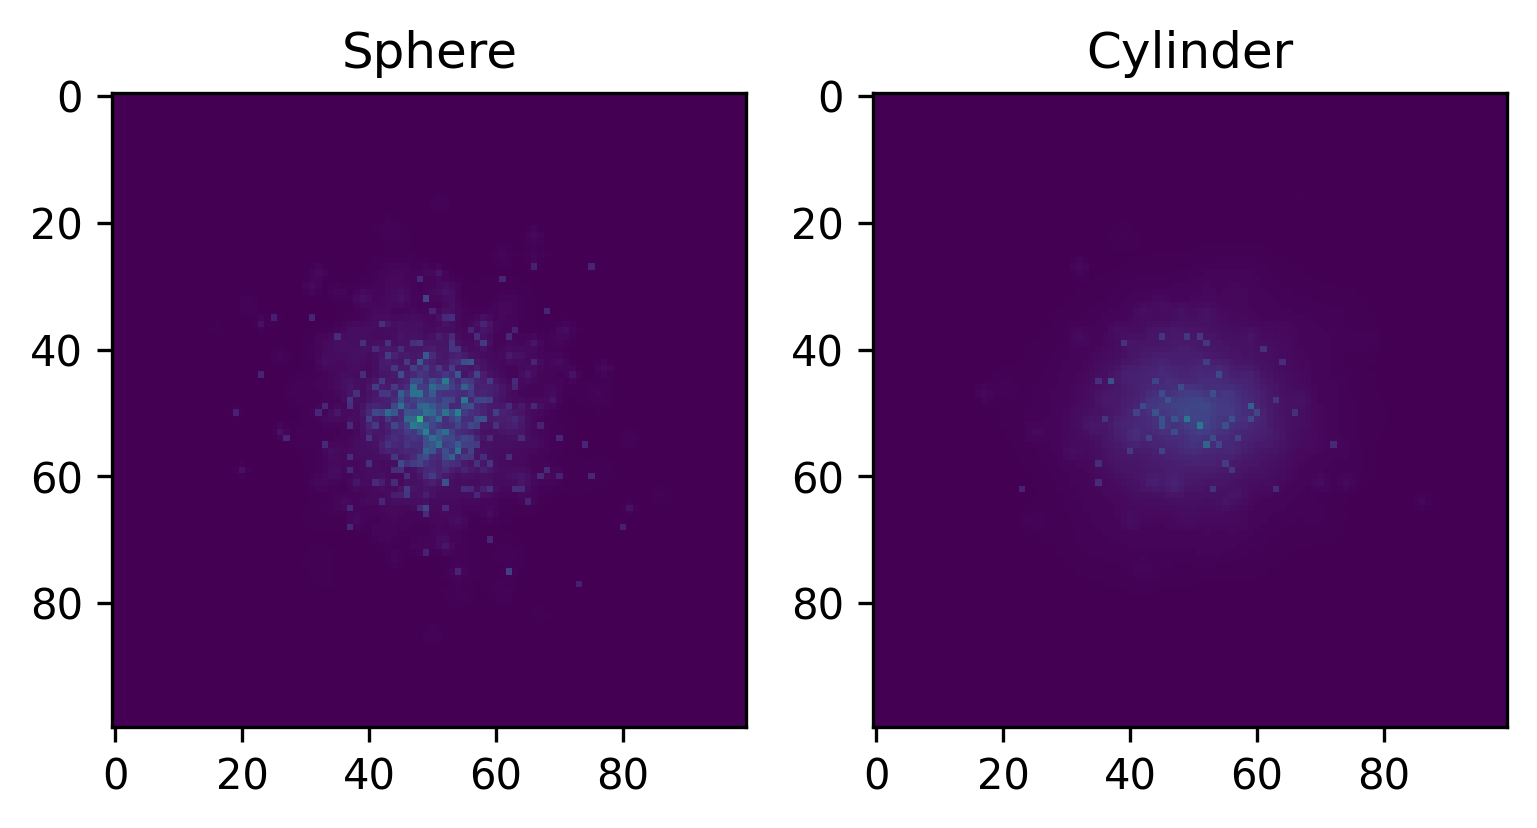

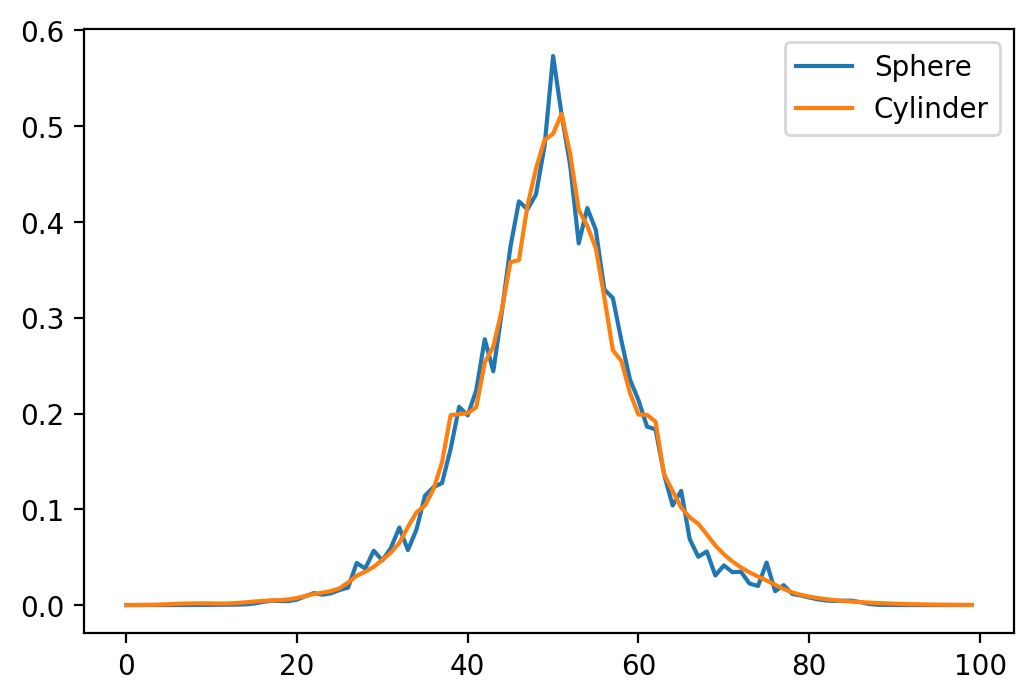

In [26]:
gaussian_sph = np.array(sph)
gaussian_cyl = np.array(cyl)

m = 10

fraction = 0.5

for x in range(gaussian_sph.shape[2]):
    gaussian_sph[:,:,x] = gaussian(sph[:,:,x], sigma=gaussian_sigma(x,fraction*gaussian_sph.shape[2],maximum=m))
    
for x in range(gaussian_cyl.shape[2]):
    gaussian_cyl[:,:,x] = gaussian(cyl[:,:,x], sigma=gaussian_sigma(x,fraction*cyl.shape[2],maximum=m))

fig, axs = plt.subplots(1,2,dpi=300)
    
axs[0].imshow(np.sum(gaussian_sph, axis = 2), vmin = 0, vmax = 10)
axs[1].imshow(np.sum(gaussian_cyl, axis = 2), vmin = 0, vmax = 10)
axs[0].set(title = 'Sphere')
axs[1].set(title = 'Cylinder')


fig2, ax2 = plt.subplots(dpi = 200)

ax2.plot(np.average(np.sum(gaussian_sph, axis = 2),axis = 1))
ax2.plot(np.average(np.sum(gaussian_cyl, axis = 2),axis = 1))
ax2.legend(['Sphere','Cylinder'])